Diffusion models have become one of the most powerful approaches for generative modeling, powering everything from DALL-E to Stable Diffusion. At their core, they work by gradually adding noise to data and then learning to reverse this process. 

The key insight is surprisingly simple: if we can learn to denoise images at different noise levels, we can generate new images by starting with pure noise and progressively denoising it. This tutorial implements a minimal diffusion model using PyTorch and the sklearn digits dataset.

## The Math Behind Diffusion

The diffusion process consists of two parts:

**Forward Process (Adding Noise):** We gradually add Gaussian noise to clean images over $T$ timesteps:
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

**Reverse Process (Denoising):** We learn to reverse this process:
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

The beautiful mathematical insight is that we can train a neural network to predict the noise $\epsilon$ that was added, rather than directly predicting the clean image.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import seaborn as sns
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load and Explore the Data

We'll use the sklearn digits dataset, which contains 8×8 grayscale images of handwritten digits 0-9. This is perfect for our minimal implementation as the images are small and the dataset is manageable.

The dataset contains 1,797 samples, each representing a digit as a 64-dimensional vector (8×8 flattened). We'll normalize the pixel values to the range [0, 1] to match the assumptions of our diffusion model.

In [ ]:
# Load and prepare the digits dataset
digits = load_digits()
X = digits.data.reshape(-1, 8, 8)  # 8x8 images
X = X / 16.0  # Normalize to [0, 1] (original max value is 16)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension: [N, 1, 8, 8]

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset shape: {X_tensor.shape}")
print(f"Data range: [{X_tensor.min():.3f}, {X_tensor.max():.3f}]")
print(f"Number of samples: {len(X_tensor)}")
print(f"Unique digits: {np.unique(digits.target)}")

In [ ]:
# Show overall data distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(digits.target, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Digits')
plt.xlabel('Digit')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(X.flatten(), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
mean_image = X.mean(axis=0)
plt.imshow(mean_image, cmap='gray')
plt.title('Mean Image Across Dataset')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the diffusion scheduler
class DiffusionScheduler:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the diffusion scheduler with a linear beta schedule.
        
        Args:
            num_timesteps: Number of diffusion steps
            beta_start: Starting value for beta schedule
            beta_end: Ending value for beta schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear schedule for beta values
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Useful for sampling
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
    def add_noise(self, x0, t, noise=None):
        """
        Add noise to clean images at timestep t using the reparameterization trick.
        
        Args:
            x0: Clean images [batch_size, channels, height, width]
            t: Timesteps [batch_size]
            noise: Optional noise tensor, will be generated if None
            
        Returns:
            Noisy images at timestep t
        """
        if noise is None:
            noise = torch.randn_like(x0)
        
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])
        
        # Reshape for broadcasting
        sqrt_alphas_cumprod = sqrt_alphas_cumprod.view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.view(-1, 1, 1, 1)
        
        return sqrt_alphas_cumprod * x0 + sqrt_one_minus_alphas_cumprod * noise

scheduler = DiffusionScheduler()
print(f"Scheduler initialized with {scheduler.num_timesteps} timesteps")

In [ ]:
# Demonstrate the forward diffusion process
sample_image = X_tensor[0:1]  # Take first image
timesteps = [0, 50, 100, 200, 400, 600, 800, 999]

fig, axes = plt.subplots(2, len(timesteps), figsize=(20, 6))
fig.suptitle('Forward Diffusion Process: Gradual Noise Addition', fontsize=16)

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t])
    noisy_image = scheduler.add_noise(sample_image, t_tensor)
    
    # Show image
    axes[0, i].imshow(noisy_image[0, 0].numpy(), cmap='gray')
    axes[0, i].set_title(f't = {t}')
    axes[0, i].axis('off')
    
    # Show histogram of pixel values
    axes[1, i].hist(noisy_image[0, 0].flatten().numpy(), bins=20, alpha=0.7, color=f'C{i}')
    axes[1, i].set_title(f'Histogram t={t}')
    axes[1, i].set_xlim([-3, 3])
    axes[1, i].set_ylim([0, 20])

plt.tight_layout()
plt.show()

In [ ]:
# Time embedding using sinusoidal positional encoding
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding similar to transformers"""
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        
    def forward(self, t):
        device = t.device
        half_dim = self.embed_dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings

In [ ]:
# Create and test the model
model = ImprovedDenoiser()
total_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {total_params:,} parameters")

# Test the model
test_input = torch.randn(2, 1, 8, 8)
test_time = torch.randint(0, 1000, (2,))
test_output = model(test_input, test_time)
print(f"Test input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")
print(f"Model successfully processes input → output")

In [ ]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
scheduler.betas = scheduler.betas.to(device)
scheduler.alphas = scheduler.alphas.to(device)
scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
criterion = nn.MSELoss()

num_epochs = 50
losses = []
epoch_losses = []

print(f"Training on device: {device}")
print(f"Training for {num_epochs} epochs with {len(dataloader)} batches per epoch")

In [ ]:
# Plot training progress
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss over batches
axes[0].plot(losses, alpha=0.7)
axes[0].set_title('Training Loss (per batch)')
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('MSE Loss')
axes[0].grid(True)

# Loss over epochs
axes[1].plot(epoch_losses, 'o-')
axes[1].set_title('Training Loss (per epoch)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average MSE Loss')
axes[1].grid(True)

# Loss distribution
axes[2].hist(losses, bins=50, alpha=0.7, edgecolor='black')
axes[2].set_title('Distribution of Batch Losses')
axes[2].set_xlabel('Loss')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Define sampling function
def sample_images(model, scheduler, num_samples=8, device='cpu', show_progress=True):
    """Generate images using the trained diffusion model"""
    model.eval()
    
    with torch.no_grad():
        # Start with pure noise
        x = torch.randn(num_samples, 1, 8, 8, device=device)
        
        # Store intermediate steps for visualization
        intermediate_steps = []
        save_steps = [999, 800, 600, 400, 200, 100, 50, 0]
        
        # Reverse diffusion process
        iterator = reversed(range(scheduler.num_timesteps))
        if show_progress:
            iterator = tqdm(iterator, desc="Sampling")
            
        for i, t in enumerate(iterator):
            t_tensor = torch.full((num_samples,), t, device=device)
            
            # Predict noise
            predicted_noise = model(x, t_tensor)
            
            # Remove predicted noise
            alpha_t = scheduler.alphas[t]
            alpha_cumprod_t = scheduler.alphas_cumprod[t]
            beta_t = scheduler.betas[t]
            
            # Compute x_{t-1}
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)
            
            # Add noise if not the last step
            if t > 0:
                noise = torch.randn_like(x)
                x = x + torch.sqrt(beta_t) * noise
            
            # Save intermediate steps
            if t in save_steps:
                intermediate_steps.append((t, x.clone().cpu()))
    
    return x.cpu(), intermediate_steps

In [ ]:
# Show quality metrics
print("Generated Image Statistics:")
print(f"Mean pixel value: {generated_images.mean():.3f}")
print(f"Std pixel value: {generated_images.std():.3f}")
print(f"Min pixel value: {generated_images.min():.3f}")
print(f"Max pixel value: {generated_images.max():.3f}")

print("\nOriginal Image Statistics:")
print(f"Mean pixel value: {X_tensor.mean():.3f}")
print(f"Std pixel value: {X_tensor.std():.3f}")
print(f"Min pixel value: {X_tensor.min():.3f}")
print(f"Max pixel value: {X_tensor.max():.3f}")

In [ ]:
# Visualize the reverse diffusion process
intermediates = all_intermediates[0]  # Use first batch's intermediates

fig, axes = plt.subplots(len(intermediates), 8, figsize=(16, 20))
fig.suptitle('Reverse Diffusion Process: From Noise to Digits', fontsize=16)

for step_idx, (timestep, images) in enumerate(intermediates):
    for sample_idx in range(8):
        axes[step_idx, sample_idx].imshow(images[sample_idx, 0], cmap='gray')
        axes[step_idx, sample_idx].axis('off')
        if sample_idx == 0:
            axes[step_idx, sample_idx].set_ylabel(f't = {timestep}', fontsize=12)
        if step_idx == 0:
            axes[step_idx, sample_idx].set_title(f'Sample {sample_idx+1}', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Show pixel intensity evolution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot mean pixel intensity over time
mean_intensities = []
std_intensities = []
timesteps_list = []

for timestep, images in intermediates:
    mean_intensities.append(images.mean().item())
    std_intensities.append(images.std().item())
    timesteps_list.append(timestep)

axes[0].plot(timesteps_list, mean_intensities, 'o-', label='Mean Intensity')
axes[0].fill_between(timesteps_list, 
                     np.array(mean_intensities) - np.array(std_intensities),
                     np.array(mean_intensities) + np.array(std_intensities),
                     alpha=0.3)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Pixel Intensity')
axes[0].set_title('Pixel Intensity Evolution During Sampling')
axes[0].legend()
axes[0].grid(True)

# Show histogram evolution
sample_images = [images[0, 0].numpy().flatten() for _, images in intermediates]
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_images)))

for i, (pixels, color) in enumerate(zip(sample_images, colors)):
    axes[1].hist(pixels, bins=30, alpha=0.5, color=color, 
                label=f't={timesteps_list[i]}' if i % 2 == 0 else '')

axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Pixel Value Distribution Evolution')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create detailed animation function
def create_detailed_animation():
    """Create detailed animation frames showing the full reverse process"""
    model.eval()
    
    with torch.no_grad():
        # Start with pure noise (single sample for cleaner animation)
        x = torch.randn(1, 1, 8, 8, device=device)
        
        # Store ALL intermediate steps
        all_frames = []
        
        # Reverse diffusion process
        for t in tqdm(reversed(range(scheduler.num_timesteps)), desc="Creating animation"):
            # Save every 50th frame to keep animation manageable
            if t % 50 == 0 or t < 50:
                all_frames.append((t, x[0, 0].cpu().numpy().copy()))
            
            t_tensor = torch.full((1,), t, device=device)
            
            # Predict noise
            predicted_noise = model(x, t_tensor)
            
            # Remove predicted noise
            alpha_t = scheduler.alphas[t]
            alpha_cumprod_t = scheduler.alphas_cumprod[t]
            beta_t = scheduler.betas[t]
            
            # Compute x_{t-1}
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)
            
            # Add noise if not the last step
            if t > 0:
                noise = torch.randn_like(x)
                x = x + torch.sqrt(beta_t) * noise
    
    return all_frames

# Create animation frames
print("Creating detailed animation frames...")
animation_frames = create_detailed_animation()

In [ ]:
# Show final comparison
fig, axes = plt.subplots(len(comparison_frames), 4, figsize=(12, 20))
fig.suptitle('Multiple Samples Diffusion Process', fontsize=16)

for step_idx, (timestep, images) in enumerate(comparison_frames):
    for sample_idx in range(4):
        axes[step_idx, sample_idx].imshow(images[sample_idx, 0], cmap='gray')
        axes[step_idx, sample_idx].axis('off')
        if sample_idx == 0:
            axes[step_idx, sample_idx].set_ylabel(f't = {timestep}', fontsize=10)
        if step_idx == 0:
            axes[step_idx, sample_idx].set_title(f'Sample {sample_idx+1}', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Created {len(animation_frames)} animation frames")
print(f"Created {len(comparison_frames)} comparison frames")

In [ ]:
# Show key frames from the animation
key_frames = animation_frames[::len(animation_frames)//8]  # Show 8 key frames
fig, axes = plt.subplots(1, len(key_frames), figsize=(20, 3))
fig.suptitle('Key Frames from Diffusion Animation', fontsize=16)

for i, (timestep, image) in enumerate(key_frames):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f't = {timestep}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Create and save animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')

def animate(frame_idx):
    ax.clear()
    timestep, image = animation_frames[frame_idx]
    
    # Display the image
    im = ax.imshow(image, cmap='gray', vmin=-2, vmax=2)
    ax.set_title(f'Diffusion Sampling: t = {timestep}', fontsize=14)
    ax.axis('off')
    
    return [im]

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(animation_frames), 
                             interval=200, blit=False, repeat=True)

# Save as GIF
print("Saving animation as GIF...")
anim.save('diffusion_process.gif', writer='pillow', fps=5)
print("Animation saved as 'diffusion_process.gif'")

# Display the animation in notebook
plt.show()

In [ ]:
# Show the progression for a single sample
sample_idx = 0
fig, axes = plt.subplots(1, len(intermediates), figsize=(20, 3))
fig.suptitle(f'Single Sample Progression: From Noise to Digit', fontsize=16)

for step_idx, (timestep, images) in enumerate(intermediates):
    axes[step_idx].imshow(images[sample_idx, 0], cmap='gray')
    axes[step_idx].set_title(f't = {timestep}')
    axes[step_idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Show multiple generations
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
fig.suptitle('Multiple Generated Samples (5 batches × 8 samples)', fontsize=16)

for batch_idx in range(5):
    for sample_idx in range(8):
        img_idx = batch_idx * 8 + sample_idx
        axes[batch_idx, sample_idx].imshow(generated_images[img_idx, 0], cmap='gray')
        axes[batch_idx, sample_idx].axis('off')
        axes[batch_idx, sample_idx].set_title(f'B{batch_idx+1}S{sample_idx+1}', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Generate multiple batches of samples
print("Generating samples...")
all_samples = []
all_intermediates = []

for i in range(5):  # Generate 5 batches of 8 samples each
    samples, intermediates = sample_images(model, scheduler, num_samples=8, device=device, show_progress=(i==0))
    all_samples.append(samples)
    all_intermediates.append(intermediates)
    print(f"Generated batch {i+1}/5")

# Combine all samples
generated_images = torch.cat(all_samples, dim=0)
print(f"Generated {len(generated_images)} total images")

In [ ]:
# Self-attention mechanism
class AttentionBlock(nn.Module):
    """Simple self-attention block"""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        qkv = self.qkv(x_norm)
        q, k, v = qkv.chunk(3, dim=1)
        
        # Reshape for attention
        q = q.view(b, c, h * w).transpose(1, 2)
        k = k.view(b, c, h * w).transpose(1, 2)
        v = v.view(b, c, h * w).transpose(1, 2)
        
        # Compute attention
        attn = torch.softmax(q @ k.transpose(-2, -1) / (c ** 0.5), dim=-1)
        out = attn @ v
        
        # Reshape back
        out = out.transpose(1, 2).view(b, c, h, w)
        out = self.proj(out)
        
        return x + out

In [ ]:
# Residual block with time conditioning
class ResidualBlock(nn.Module):
    """Residual block with time conditioning"""
    def __init__(self, in_channels, out_channels, time_embed_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embed_dim, out_channels),
            nn.ReLU()
        )
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x, time_emb):
        # First convolution
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.relu(h)
        
        # Add time conditioning
        time_cond = self.time_mlp(time_emb)
        h = h + time_cond.unsqueeze(-1).unsqueeze(-1)
        
        # Second convolution
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)
        
        # Skip connection
        return h + self.shortcut(x)

## Forward Diffusion Process: Adding Noise

The forward diffusion process gradually corrupts clean images by adding Gaussian noise. The key insight is that we can jump to any timestep $t$ directly using the reparameterization trick:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$

where:
- $x_0$ is the clean image
- $\epsilon \sim \mathcal{N}(0, I)$ is random noise
- $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$ is the cumulative product of alphas
- $\alpha_t = 1 - \beta_t$ where $\beta_t$ is the noise schedule

This allows us to efficiently sample noisy images at any timestep during training without having to iteratively apply the forward process.

In [ ]:
class DiffusionScheduler:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the diffusion scheduler with a linear beta schedule.
        
        Args:
            num_timesteps: Number of diffusion steps
            beta_start: Starting value for beta schedule
            beta_end: Ending value for beta schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear schedule for beta values
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Useful for sampling
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
    def add_noise(self, x0, t, noise=None):
        """
        Add noise to clean images at timestep t using the reparameterization trick.
        
        Args:
            x0: Clean images [batch_size, channels, height, width]
            t: Timesteps [batch_size]
            noise: Optional noise tensor, will be generated if None
            
        Returns:
            Noisy images at timestep t
        """
        if noise is None:
            noise = torch.randn_like(x0)
        
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])
        
        # Reshape for broadcasting
        sqrt_alphas_cumprod = sqrt_alphas_cumprod.view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.view(-1, 1, 1, 1)
        
        return sqrt_alphas_cumprod * x0 + sqrt_one_minus_alphas_cumprod * noise

scheduler = DiffusionScheduler()
print(f"Scheduler initialized with {scheduler.num_timesteps} timesteps")

# Visualize the noise schedule
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Beta schedule
axes[0].plot(scheduler.betas.numpy())
axes[0].set_title('Beta Schedule (Noise Rate)')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Beta')
axes[0].grid(True)

# Alpha schedule
axes[1].plot(scheduler.alphas.numpy())
axes[1].set_title('Alpha Schedule (1 - Beta)')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Alpha')
axes[1].grid(True)

# Cumulative alpha schedule
axes[2].plot(scheduler.alphas_cumprod.numpy())
axes[2].set_title('Cumulative Alpha Schedule')
axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Cumulative Alpha')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Show the forward diffusion process on a sample image
sample_image = X_tensor[0:1]  # Take first image
timesteps = [0, 50, 100, 200, 400, 600, 800, 999]

fig, axes = plt.subplots(2, len(timesteps), figsize=(20, 6))
fig.suptitle('Forward Diffusion Process: Gradual Noise Addition', fontsize=16)

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t])
    noisy_image = scheduler.add_noise(sample_image, t_tensor)
    
    # Show image
    axes[0, i].imshow(noisy_image[0, 0].numpy(), cmap='gray')
    axes[0, i].set_title(f't = {t}')
    axes[0, i].axis('off')
    
    # Show histogram of pixel values
    axes[1, i].hist(noisy_image[0, 0].flatten().numpy(), bins=20, alpha=0.7, color=f'C{i}')
    axes[1, i].set_title(f'Histogram t={t}')
    axes[1, i].set_xlim([-3, 3])
    axes[1, i].set_ylim([0, 20])

plt.tight_layout()
plt.show()

## Improved Denoising Model Architecture

Our denoising model needs to predict the noise $\epsilon_\theta(x_t, t)$ that was added to create the noisy image $x_t$. The model takes two inputs:
1. **Noisy image** $x_t$ at timestep $t$
2. **Timestep** $t$ (embedded as a feature)

The key architectural components are:

1. **Time Embedding**: We embed the timestep $t$ using sinusoidal positional encoding (similar to transformers)
2. **U-Net-like Architecture**: We use a simplified U-Net with residual connections and attention
3. **Residual Blocks**: Each block combines convolution, normalization, and time conditioning
4. **Attention Mechanism**: Simple self-attention to capture long-range dependencies

The loss function is simply the Mean Squared Error between predicted and actual noise:
$$\mathcal{L} = \mathbb{E}_{t,x_0,\epsilon} [||\epsilon - \epsilon_\theta(x_t, t)||^2]$$

In [ ]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding similar to transformers"""
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        
    def forward(self, t):
        device = t.device
        half_dim = self.embed_dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings

class ResidualBlock(nn.Module):
    """Residual block with time conditioning"""
    def __init__(self, in_channels, out_channels, time_embed_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embed_dim, out_channels),
            nn.ReLU()
        )
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x, time_emb):
        # First convolution
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.relu(h)
        
        # Add time conditioning
        time_cond = self.time_mlp(time_emb)
        h = h + time_cond.unsqueeze(-1).unsqueeze(-1)
        
        # Second convolution
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)
        
        # Skip connection
        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    """Simple self-attention block"""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        qkv = self.qkv(x_norm)
        q, k, v = qkv.chunk(3, dim=1)
        
        # Reshape for attention
        q = q.view(b, c, h * w).transpose(1, 2)
        k = k.view(b, c, h * w).transpose(1, 2)
        v = v.view(b, c, h * w).transpose(1, 2)
        
        # Compute attention
        attn = torch.softmax(q @ k.transpose(-2, -1) / (c ** 0.5), dim=-1)
        out = attn @ v
        
        # Reshape back
        out = out.transpose(1, 2).view(b, c, h, w)
        out = self.proj(out)
        
        return x + out

class ImprovedDenoiser(nn.Module):
    """Improved U-Net-like denoiser with time conditioning and attention"""
    def __init__(self, in_channels=1, model_channels=64, time_embed_dim=128):
        super().__init__()
        
        self.time_embed = nn.Sequential(
            TimeEmbedding(time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )
        
        # Encoder
        self.init_conv = nn.Conv2d(in_channels, model_channels, 3, padding=1)
        
        self.down1 = ResidualBlock(model_channels, model_channels, time_embed_dim)
        self.down2 = ResidualBlock(model_channels, model_channels * 2, time_embed_dim)
        self.down3 = ResidualBlock(model_channels * 2, model_channels * 4, time_embed_dim)
        
        # Middle with attention
        self.mid = ResidualBlock(model_channels * 4, model_channels * 4, time_embed_dim)
        self.mid_attn = AttentionBlock(model_channels * 4)
        
        # Decoder
        self.up1 = ResidualBlock(model_channels * 4, model_channels * 2, time_embed_dim)
        self.up2 = ResidualBlock(model_channels * 2, model_channels, time_embed_dim)
        self.up3 = ResidualBlock(model_channels, model_channels, time_embed_dim)
        
        # Output
        self.out_conv = nn.Conv2d(model_channels, in_channels, 3, padding=1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t.float())
        
        # Initial convolution
        x = self.init_conv(x)
        
        # Encoder
        x1 = self.down1(x, t_emb)
        x2 = self.down2(x1, t_emb)
        x3 = self.down3(x2, t_emb)
        
        # Middle
        x = self.mid(x3, t_emb)
        x = self.mid_attn(x)
        
        # Decoder (with skip connections)
        x = self.up1(x + x3, t_emb)
        x = self.up2(x + x2, t_emb)
        x = self.up3(x + x1, t_emb)
        
        # Output
        return self.out_conv(x)

# Create the improved model
model = ImprovedDenoiser()
total_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {total_params:,} parameters")

# Test the model
test_input = torch.randn(2, 1, 8, 8)
test_time = torch.randint(0, 1000, (2,))
test_output = model(test_input, test_time)
print(f"Test input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")
print(f"Model successfully processes input → output")

## Training the Denoising Model

Now we train our model to predict the noise that was added to images. The training process is surprisingly simple:

1. **Sample a batch** of clean images $x_0$
2. **Sample random timesteps** $t$ for each image
3. **Sample noise** $\epsilon \sim \mathcal{N}(0, I)$
4. **Create noisy images** $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
5. **Predict the noise** $\epsilon_\theta(x_t, t)$
6. **Compute loss** $\mathcal{L} = ||\epsilon - \epsilon_\theta(x_t, t)||^2$

The key insight is that by training on all timesteps simultaneously, the model learns to denoise at any level of noise corruption.

In [ ]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
scheduler.betas = scheduler.betas.to(device)
scheduler.alphas = scheduler.alphas.to(device)
scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
criterion = nn.MSELoss()

num_epochs = 50
losses = []
epoch_losses = []

print(f"Training on device: {device}")
print(f"Training for {num_epochs} epochs with {len(dataloader)} batches per epoch")

# Training loop with progress tracking
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_losses = []
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (x0,) in enumerate(pbar):
        x0 = x0.to(device)
        batch_size = x0.size(0)
        
        # Sample random timesteps
        t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
        
        # Generate noise
        noise = torch.randn_like(x0)
        
        # Add noise to clean images
        x_noisy = scheduler.add_noise(x0, t, noise)
        
        # Predict noise
        predicted_noise = model(x_noisy, t)
        
        # Compute loss
        loss = criterion(predicted_noise, noise)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        # Track losses
        batch_loss = loss.item()
        epoch_loss += batch_loss
        batch_losses.append(batch_loss)
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{batch_loss:.4f}'})
    
    avg_loss = epoch_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    losses.extend(batch_losses)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    
    # Save some intermediate results every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Test denoising on a sample
            sample_x0 = X_tensor[0:1].to(device)
            sample_t = torch.tensor([500], device=device)
            sample_noise = torch.randn_like(sample_x0)
            sample_noisy = scheduler.add_noise(sample_x0, sample_t, sample_noise)
            sample_pred_noise = model(sample_noisy, sample_t)
            
            # Show denoising quality
            print(f"  Noise prediction MSE: {F.mse_loss(sample_pred_noise, sample_noise):.4f}")

print("Training completed!")

# Plot training progress
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss over batches
axes[0].plot(losses, alpha=0.7)
axes[0].set_title('Training Loss (per batch)')
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('MSE Loss')
axes[0].grid(True)

# Loss over epochs
axes[1].plot(epoch_losses, 'o-')
axes[1].set_title('Training Loss (per epoch)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average MSE Loss')
axes[1].grid(True)

# Loss distribution
axes[2].hist(losses, bins=50, alpha=0.7, edgecolor='black')
axes[2].set_title('Distribution of Batch Losses')
axes[2].set_xlabel('Loss')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Reverse Diffusion: Sampling New Images

Now comes the magic! To generate new images, we reverse the diffusion process. We start with pure noise and gradually denoise it using our trained model.

The reverse process follows this formula:
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

where $z \sim \mathcal{N}(0, I)$ is additional noise (except for the final step).

This is essentially asking: "If I know the noise that was added, how can I remove it to get the less noisy image?"

In [ ]:
def sample_images(model, scheduler, num_samples=8, device='cpu', show_progress=True):
    """Generate images using the trained diffusion model"""
    model.eval()
    
    with torch.no_grad():
        # Start with pure noise
        x = torch.randn(num_samples, 1, 8, 8, device=device)
        
        # Store intermediate steps for visualization
        intermediate_steps = []
        save_steps = [999, 800, 600, 400, 200, 100, 50, 0]
        
        # Reverse diffusion process
        iterator = reversed(range(scheduler.num_timesteps))
        if show_progress:
            iterator = tqdm(iterator, desc="Sampling")
            
        for i, t in enumerate(iterator):
            t_tensor = torch.full((num_samples,), t, device=device)
            
            # Predict noise
            predicted_noise = model(x, t_tensor)
            
            # Remove predicted noise
            alpha_t = scheduler.alphas[t]
            alpha_cumprod_t = scheduler.alphas_cumprod[t]
            beta_t = scheduler.betas[t]
            
            # Compute x_{t-1}
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)
            
            # Add noise if not the last step
            if t > 0:
                noise = torch.randn_like(x)
                x = x + torch.sqrt(beta_t) * noise
            
            # Save intermediate steps
            if t in save_steps:
                intermediate_steps.append((t, x.clone().cpu()))
    
    return x.cpu(), intermediate_steps

# Generate multiple batches of samples
print("Generating samples...")
all_samples = []
all_intermediates = []

for i in range(5):  # Generate 5 batches of 8 samples each
    samples, intermediates = sample_images(model, scheduler, num_samples=8, device=device, show_progress=(i==0))
    all_samples.append(samples)
    all_intermediates.append(intermediates)
    print(f"Generated batch {i+1}/5")

# Combine all samples
generated_images = torch.cat(all_samples, dim=0)
print(f"Generated {len(generated_images)} total images")

# Show multiple generations
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
fig.suptitle('Multiple Generated Samples (5 batches × 8 samples)', fontsize=16)

for batch_idx in range(5):
    for sample_idx in range(8):
        img_idx = batch_idx * 8 + sample_idx
        axes[batch_idx, sample_idx].imshow(generated_images[img_idx, 0], cmap='gray')
        axes[batch_idx, sample_idx].axis('off')
        axes[batch_idx, sample_idx].set_title(f'B{batch_idx+1}S{sample_idx+1}', fontsize=8)

plt.tight_layout()
plt.show()

# Compare with original digits
fig, axes = plt.subplots(2, 10, figsize=(20, 6))
fig.suptitle('Original Digits vs Generated Samples', fontsize=16)

# Original digits (one of each class)
for i in range(10):
    digit_idx = np.where(digits.target == i)[0][0]
    axes[0, i].imshow(X[digit_idx], cmap='gray')
    axes[0, i].set_title(f'Original {i}')
    axes[0, i].axis('off')

# Generated samples
for i in range(10):
    axes[1, i].imshow(generated_images[i, 0], cmap='gray')
    axes[1, i].set_title(f'Generated {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Show quality metrics
print("\nGenerated Image Statistics:")
print(f"Mean pixel value: {generated_images.mean():.3f}")
print(f"Std pixel value: {generated_images.std():.3f}")
print(f"Min pixel value: {generated_images.min():.3f}")
print(f"Max pixel value: {generated_images.max():.3f}")

print("\nOriginal Image Statistics:")
print(f"Mean pixel value: {X_tensor.mean():.3f}")
print(f"Std pixel value: {X_tensor.std():.3f}")
print(f"Min pixel value: {X_tensor.min():.3f}")
print(f"Max pixel value: {X_tensor.max():.3f}")

## Visualizing the Reverse Process

Let's see how the denoising process works step by step. We'll track the intermediate states as we go from pure noise to clean digits.

In [ ]:
# Visualize the reverse diffusion process
intermediates = all_intermediates[0]  # Use first batch's intermediates

fig, axes = plt.subplots(len(intermediates), 8, figsize=(16, 20))
fig.suptitle('Reverse Diffusion Process: From Noise to Digits', fontsize=16)

for step_idx, (timestep, images) in enumerate(intermediates):
    for sample_idx in range(8):
        axes[step_idx, sample_idx].imshow(images[sample_idx, 0], cmap='gray')
        axes[step_idx, sample_idx].axis('off')
        if sample_idx == 0:
            axes[step_idx, sample_idx].set_ylabel(f't = {timestep}', fontsize=12)
        if step_idx == 0:
            axes[step_idx, sample_idx].set_title(f'Sample {sample_idx+1}', fontsize=10)

plt.tight_layout()
plt.show()

# Show the progression for a single sample
sample_idx = 0
fig, axes = plt.subplots(1, len(intermediates), figsize=(20, 3))
fig.suptitle(f'Single Sample Progression: From Noise to Digit', fontsize=16)

for step_idx, (timestep, images) in enumerate(intermediates):
    axes[step_idx].imshow(images[sample_idx, 0], cmap='gray')
    axes[step_idx].set_title(f't = {timestep}')
    axes[step_idx].axis('off')

plt.tight_layout()
plt.show()

# Create a simple animation frame sequence
def create_animation_frames():
    """Create frames for animation"""
    frames = []
    sample_idx = 0
    
    for timestep, images in intermediates:
        frames.append(images[sample_idx, 0].numpy())
    
    return frames

# Create and display animation frames
animation_frames = create_animation_frames()

# Show animation frames in a grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Animation Frames: Reverse Diffusion Process', fontsize=16)

for i, frame in enumerate(animation_frames):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(frame, cmap='gray')
    axes[row, col].set_title(f'Frame {i+1}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Show pixel intensity evolution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot mean pixel intensity over time
mean_intensities = []
std_intensities = []
timesteps_list = []

for timestep, images in intermediates:
    mean_intensities.append(images.mean().item())
    std_intensities.append(images.std().item())
    timesteps_list.append(timestep)

axes[0].plot(timesteps_list, mean_intensities, 'o-', label='Mean Intensity')
axes[0].fill_between(timesteps_list, 
                     np.array(mean_intensities) - np.array(std_intensities),
                     np.array(mean_intensities) + np.array(std_intensities),
                     alpha=0.3)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Pixel Intensity')
axes[0].set_title('Pixel Intensity Evolution During Sampling')
axes[0].legend()
axes[0].grid(True)

# Show histogram evolution
sample_images = [images[0, 0].numpy().flatten() for _, images in intermediates]
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_images)))

for i, (pixels, color) in enumerate(zip(sample_images, colors)):
    axes[1].hist(pixels, bins=30, alpha=0.5, color=color, 
                label=f't={timesteps_list[i]}' if i % 2 == 0 else '')

axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Pixel Value Distribution Evolution')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Creating an Animated GIF

Let's create an animated visualization of the diffusion process to really see how the model transforms noise into recognizable digits!

In [ ]:
# Create a detailed animation of the reverse diffusion process
def create_detailed_animation():
    """Create detailed animation frames showing the full reverse process"""
    model.eval()
    
    with torch.no_grad():
        # Start with pure noise (single sample for cleaner animation)
        x = torch.randn(1, 1, 8, 8, device=device)
        
        # Store ALL intermediate steps
        all_frames = []
        
        # Reverse diffusion process
        for t in tqdm(reversed(range(scheduler.num_timesteps)), desc="Creating animation"):
            # Save every 50th frame to keep animation manageable
            if t % 50 == 0 or t < 50:
                all_frames.append((t, x[0, 0].cpu().numpy().copy()))
            
            t_tensor = torch.full((1,), t, device=device)
            
            # Predict noise
            predicted_noise = model(x, t_tensor)
            
            # Remove predicted noise
            alpha_t = scheduler.alphas[t]
            alpha_cumprod_t = scheduler.alphas_cumprod[t]
            beta_t = scheduler.betas[t]
            
            # Compute x_{t-1}
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)
            
            # Add noise if not the last step
            if t > 0:
                noise = torch.randn_like(x)
                x = x + torch.sqrt(beta_t) * noise
    
    return all_frames

# Create animation frames
print("Creating detailed animation frames...")
animation_frames = create_detailed_animation()

# Create the animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')

def animate(frame_idx):
    ax.clear()
    timestep, image = animation_frames[frame_idx]
    
    # Display the image
    im = ax.imshow(image, cmap='gray', vmin=-2, vmax=2)
    ax.set_title(f'Diffusion Sampling: t = {timestep}', fontsize=14)
    ax.axis('off')
    
    return [im]

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(animation_frames), 
                             interval=200, blit=False, repeat=True)

# Save as GIF
print("Saving animation as GIF...")
anim.save('diffusion_process.gif', writer='pillow', fps=5)
print("Animation saved as 'diffusion_process.gif'")

# Display the animation in notebook
plt.show()

# Show key frames from the animation
key_frames = animation_frames[::len(animation_frames)//8]  # Show 8 key frames
fig, axes = plt.subplots(1, len(key_frames), figsize=(20, 3))
fig.suptitle('Key Frames from Diffusion Animation', fontsize=16)

for i, (timestep, image) in enumerate(key_frames):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f't = {timestep}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create a side-by-side comparison animation
def create_comparison_animation():
    """Create animation showing multiple samples side by side"""
    model.eval()
    
    with torch.no_grad():
        # Start with pure noise (4 samples)
        x = torch.randn(4, 1, 8, 8, device=device)
        
        # Store frames every 25 steps
        frames = []
        
        for t in tqdm(reversed(range(scheduler.num_timesteps)), desc="Creating comparison"):
            if t % 25 == 0 or t < 25:
                frames.append((t, x.cpu().numpy().copy()))
            
            t_tensor = torch.full((4,), t, device=device)
            predicted_noise = model(x, t_tensor)
            
            alpha_t = scheduler.alphas[t]
            alpha_cumprod_t = scheduler.alphas_cumprod[t]
            beta_t = scheduler.betas[t]
            
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)
            
            if t > 0:
                noise = torch.randn_like(x)
                x = x + torch.sqrt(beta_t) * noise
    
    return frames

# Create comparison frames
comparison_frames = create_comparison_animation()

# Show final comparison
fig, axes = plt.subplots(len(comparison_frames), 4, figsize=(12, 20))
fig.suptitle('Multiple Samples Diffusion Process', fontsize=16)

for step_idx, (timestep, images) in enumerate(comparison_frames):
    for sample_idx in range(4):
        axes[step_idx, sample_idx].imshow(images[sample_idx, 0], cmap='gray')
        axes[step_idx, sample_idx].axis('off')
        if sample_idx == 0:
            axes[step_idx, sample_idx].set_ylabel(f't = {timestep}', fontsize=10)
        if step_idx == 0:
            axes[step_idx, sample_idx].set_title(f'Sample {sample_idx+1}', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Created {len(animation_frames)} animation frames")
print(f"Created {len(comparison_frames)} comparison frames")

## Key Takeaways and Next Steps

### What We've Learned

1. **Diffusion models are conceptually simple**: Add noise gradually, then learn to reverse it
2. **The reparameterization trick is key**: We can jump to any timestep directly during training
3. **Time conditioning is crucial**: The model needs to know how much noise to remove
4. **Architecture matters**: U-Net with attention works better than simple CNN
5. **Quality emerges gradually**: The model progressively refines noise into structured images

### Improvements You Could Try

1. **Better architectures**: Full U-Net, transformer-based models
2. **Advanced sampling**: DDIM, DPM-Solver for faster sampling
3. **Conditioning**: Add class labels for controlled generation
4. **Better schedules**: Cosine, learned schedules
5. **Larger datasets**: CIFAR-10, CelebA, etc.

### Applications

- **Image generation**: Create new images from noise
- **Image editing**: Inpainting, outpainting, style transfer
- **Data augmentation**: Generate training data
- **Interpolation**: Smooth transitions between images

This minimal implementation shows that diffusion models, while mathematically sophisticated, can be implemented and understood with relatively simple code. The key is understanding the forward and reverse processes and how to train a model to predict noise effectively.

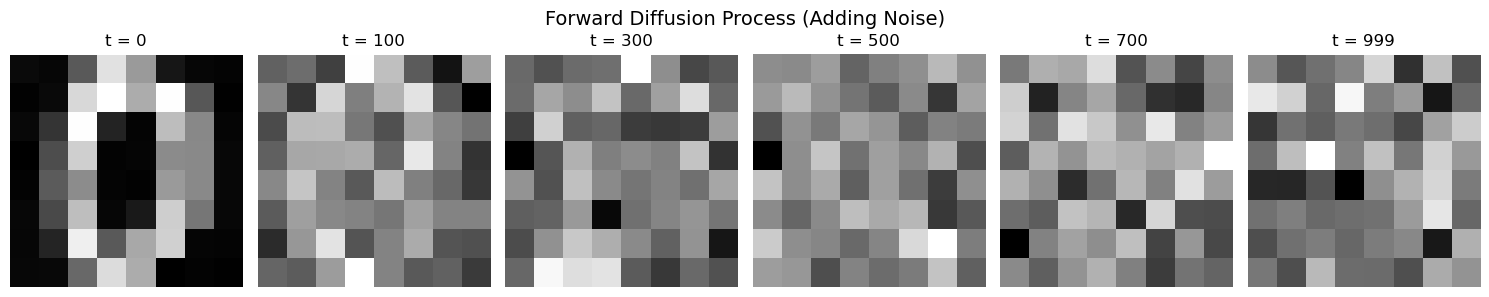

In [8]:
# Show the forward diffusion process
sample_image = X_tensor[0:1].to(device)
timesteps = [0, 100, 300, 500, 700, 999]

fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
fig.suptitle('Forward Diffusion Process (Adding Noise)', fontsize=14)

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], device=device)
    noisy_image = scheduler.add_noise(sample_image, t_tensor)
    
    axes[i].imshow(noisy_image[0, 0].cpu().numpy(), cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()